In [1]:
#Krish experimenting with ortools
#BWSI 2024 Remote Sensing Final Project: Routing Algo Working
#Routing trucks(vehicles) to shelters and hospitals to aid in disaster relief

In [2]:
#!pip install --upgrade ortools

In [25]:
#restart the kernel if you installed ortools and it doesnt find the module
import ortools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from functools import partial
import math
import csv

import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
import osmnx as os
from matplotlib import pyplot as plt, colors as mcolors
from shapely.geometry import Point, Polygon, LineString
import shapely
import numpy as np
import itertools
import time
import ast
from operator import itemgetter
from collections import Counter
from tqdm import tqdm

In [3]:
hospitals_gdf =  gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/hospitals_to_supply_2024.geojson')
hospitals_gdf['resources_needed'] = 500
hospitals_gdf['tag'] = 'hospital'

shelters_gdf = gpd.read_file('safe_shelters_day3.geojson').dropna()
shelters_gdf['resources_needed'] = 200
shelters_gdf['tag'] = 'shelter'

In [4]:
len(hospitals_gdf), len(shelters_gdf)

(80, 4071)

In [5]:
game_grid = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/game_grid_2024_post_event.geojson')

In [6]:
game_grid.head()

,MGRS,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS_10km,transport_score,DN,wind_speed,geometry
0,18TWL8392,583000mE,4592000mN,WL,18T,400000.0,18TWL89,1.0,NaN,None,"POLYGON ((-73.99395 41.47521, -74.00593 41.475..."
1,18TWL8393,583000mE,4593000mN,WL,18T,400000.0,18TWL89,0.1,7.0,None,"POLYGON ((-73.99381 41.48421, -74.00579 41.484..."
2,18TWL8394,583000mE,4594000mN,WL,18T,400000.0,18TWL89,0.2,7.0,None,"POLYGON ((-73.99367 41.49322, -74.00565 41.493..."
3,18TWL8395,583000mE,4595000mN,WL,18T,400000.0,18TWL89,0.3,8.0,None,"POLYGON ((-73.99354 41.50222, -74.00552 41.502..."
4,18TWL8396,583000mE,4596000mN,WL,18T,400000.0,18TWL89,10.0,2.0,None,"POLYGON ((-73.9934 41.51123, -74.00538 41.5113..."


In [7]:
transport_network = networkx.read_graphml('transport_network_post.graphml')

In [8]:
for index, row in game_grid.iterrows():
    node_key = row['MGRS']
    if node_key in transport_network.nodes:
        transport_network.nodes[node_key]['x'], transport_network.nodes[node_key]['y'] = row.geometry.centroid.x, row.geometry.centroid.y

# Create nodes_df
nodes_df = gpd.GeoDataFrame(index=transport_network.nodes, geometry=[Point(transport_network.nodes[node]['x'], transport_network.nodes[node]['y']) for node in transport_network.nodes])
nodes_df['MGRS'] = nodes_df.index

In [153]:
NUM_AIRFIELDS = 1
AIRFIELD_NAMES =['Westover Air Reserve Base',
                 'Evans Seaplane Base',
                 'Pheasant Field',
                 'Leavitt Airport',
                 'Cliff Dow Airport']
NUM_HOSPITALS = 3#len(hospitals_gdf)
NUM_SHELTERS = 5#len(shelters_gdf)

VEHICLES_PER_AIRFIELD = [15,6,17,1,1]
RESOURCES_PER_AIRFIELD = [2400,1200,1200]#[55354, 24558, 60796, 5442, 3850] #determined by other team members


VEHICLE_CAPACITY = 1200
NUM_VEHICLES = 40
SIMULATION_TIME =  72*60
VEHICLE_SHIFT_TIME = 720

In [154]:
w,s,e,n = game_grid.total_bounds
airfields = os.geometries_from_bbox(n, s, e, w, tags={'aeroway': 'aerodrome'})
airfields = airfields.to_crs(game_grid.crs)

airfields = airfields[airfields['name'].isin(AIRFIELD_NAMES)]
airfields['resources_needed'] = -VEHICLE_CAPACITY
airfields['tag'] = 'airfield'
airfields = airfields[['geometry', 'resources_needed','tag']]

/tmp/ipykernel_1572/13070875.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  airfields = os.geometries_from_bbox(n, s, e, w, tags={'aeroway': 'aerodrome'})
/opt/conda/lib/python3.11/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)
/opt/conda/lib/python3.11/site-packages/osmnx/_overpass.py:254: UserWarning: This area is 162 times your configured Overpass max query area size. It will automatic

In [155]:
required_airfield = pd.DataFrame(data={'geometry': Point(-72.5436, 42.1991), 'resources_needed': 0, 'tag': 'airfield'}, index=[0]) #inserting mandatory airfield at beginning
airfields_gdf = pd.concat([required_airfield, airfields]).reset_index()[['geometry','resources_needed', 'tag']]
    
airfields_gdf.head()

,geometry,resources_needed,tag
0,POINT (-72.5436 42.1991),0,airfield
1,POINT (-70.3240368 43.9510802),-1200,airfield
2,POINT (-70.815575 42.074959),-1200,airfield
3,POINT (-71.4692923 43.0384243),-1200,airfield
4,POINT (-71.170992 43.9728773),-1200,airfield


In [156]:
airfields.crs, shelters_gdf.crs, hospitals_gdf.crs

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [157]:
#construct locations gdf
#also stretches the airfields, splitting them into multiple rows based on the resources they have.

def construct_locations_gdf(airfields, hospitals, shelters):
    #creates a data matrix that stores the travel time + unloading time for every possible loctation combination, needed for or-tools
    
    hospitals_needing_supplies = hospitals.query('resources_needed > 0').sort_values(by='resources_needed', ascending=True)
    hospitals_needing_supplies['resources'] = 0
    #hospitals_needing_supplies['time_replenish_amount'] = 0
    
    shelters_needing_supplies = shelters.query('resources_needed > 0').sort_values(by='resources_needed', ascending=True)
    shelters_needing_supplies['resources'] = 0
    #shelters_needing_supplies['time_replenish_amount'] = 0

    #airfields.loc[0:,'time_replenish_amount'] = 0 #so that starting locations of vehicles dont have replenish times
    airfields_expanded = airfields.copy()
    #airfields.loc[0:,'time_replenish_amount'] = -VEHICLE_SHIFT_TIME #allows airfields to be visited by trucks to change 12-hour shifts.
    airfields_expanded['resources'] = 0
    airfields_expanded['resources_needed'] = 0 #these are the starting indexes for the vehicles
    print(airfields_expanded)

    
    for index, airfield in airfields.iterrows():

        
        resources = RESOURCES_PER_AIRFIELD[index]
        num_copies = math.floor(resources/VEHICLE_CAPACITY)-1 #remove one because vehicle starts loaded.

        airfield['resources_needed'] = -VEHICLE_CAPACITY
        
        
        for i in range(num_copies):
            airfields_expanded.loc[len(airfields_expanded)] = airfield

        remainder = resources % VEHICLE_CAPACITY
        airfield['resources_needed'] = -remainder
        airfields_expanded.loc[len(airfields_expanded)] = airfield

        airfield['resources'] = 0
        #while resources are listed as 0, lets add a bunch more rows to ensure there is enough time to distribute to vehicles(COMMENTED since routing algo changed to not use this)
        """for i in range(VEHICLES_PER_AIRFIELD[index]): #set this based on how many vehicles there are and how many times each would probably need to finish a shift(6 12hr shifts = 72hr max time)
            airfields_expanded.loc[len(airfields_expanded)] = airfield"""

        
    num_airfield_points = len(airfields_expanded)
        
    locations = pd.concat([airfields_expanded, hospitals_needing_supplies])
    locations = pd.concat([locations, shelters_needing_supplies])
    locations = locations.reset_index()[['geometry','resources_needed','resources','tag']]

    for index, loc in airfields_gdf.iterrows():
        airfields_gdf.loc[index,'geometry'] = loc['geometry'].centroid

    return locations, num_airfield_points


In [158]:
locations, num_airfield_points = construct_locations_gdf(airfields_gdf.iloc[:NUM_AIRFIELDS], hospitals_gdf.iloc[:NUM_HOSPITALS], shelters_gdf.iloc[:NUM_SHELTERS])

                   geometry  resources_needed       tag  resources
0  POINT (-72.5436 42.1991)                 0  airfield          0


In [159]:
locations = locations.reset_index()
locations

,index,geometry,resources_needed,resources,tag
0,0,POINT (-72.5436 42.1991),0,0.0,airfield
1,1,POINT (-72.5436 42.1991),-1200,NaN,airfield
2,2,POINT (-72.5436 42.1991),0,NaN,airfield
3,3,POINT (-70.93555833899995 42.982663090000074),500,0.0,hospital
4,4,POINT (-70.98471382899999 41.67274714100006),500,0.0,hospital
5,5,POINT (-71.0654 42.2775),500,0.0,hospital
6,6,POINT (-73.43376905000002 44.887701101),200,0.0,shelter
7,7,POINT (-73.06423762700001 41.329884228000026),200,0.0,shelter
8,8,POINT (-72.79004333400002 41.95600121799998),200,0.0,shelter
9,9,POINT (-71.79223654999998 42.247570413),200,0.0,shelter


In [160]:
num_airfield_points

3

In [161]:
NUM_AIRFIELD_POINTS = num_airfield_points

In [162]:
def get_closest_node(point):
    intersection = game_grid[game_grid.geometry.intersects(point)]
    
    if len(intersection) > 0:
        node_key = intersection['MGRS']
        closest_node = nodes_df[nodes_df['MGRS'].isin(node_key)].iloc[0,1]
    else:
        return None

    return closest_node

In [163]:
def get_all_location_nodes(locations):
    nodes = []
    for index, location in locations.iterrows():
        node = get_closest_node(location['geometry'])
        nodes.append(node)
    return nodes

In [164]:
#source_nodes_all_paths_df = pd.DataFrame(columns=['source_node','all_useful_paths_list']) #only run if you have no df to use to speed up matrix

In [165]:
def create_data_matrix_better(locations, source_nodes_all_paths_df):

    size = len(locations)
    time_matrix = np.zeros((size,size))
    print("getting nodes")
    loc_nodes = Counter(get_all_location_nodes(locations))
    count = 0
    print('nodes got')
    for row, loc_node in enumerate(loc_nodes):
        if loc_node == None:
            time_matrix[row] = VEHICLE_SHIFT_TIME+1

        else:
            mask = source_nodes_all_paths_df['source_node'] == loc_node
            match = source_nodes_all_paths_df[mask].dropna()
            
            if len(match) > 0: #we've already done this computation before
                all_useful_paths_list = ast.literal_eval(match.iloc[0]['all_useful_paths_list'])
                count+= 1
    
            else: #we haven't, run the networkx algo
                all_paths = networkx.single_source_shortest_path_length(transport_network, loc_node, cutoff=VEHICLE_SHIFT_TIME)

                all_useful_paths_list = []
                for node in loc_nodes:
                    count = loc_nodes[node]
                    if node in all_paths:
                        path_time = all_paths[node]
                        all_useful_paths_list.extend([abs(path_time)] * count)
                    else:
                        all_useful_paths_list.extend([VEHICLE_SHIFT_TIME+1] * count)

                source_nodes_all_paths_df = pd.concat([pd.DataFrame(data=[[loc_node,str(all_paths)]],columns=source_nodes_all_paths_df.columns),source_nodes_all_paths_df])
                time_matrix[row] = all_useful_paths_list
                count+= 1
    print("rows completed: " + str(count))
    time_matrix = np.nan_to_num(time_matrix, nan=0)
    

    demand_list = list(locations['resources_needed'])

    #vehicle_time_resetters_list = list(locations['time_replenish_amount'])

    source_nodes_all_paths_df = source_nodes_all_paths_df.reset_index()[['source_node','all_useful_paths_list']]
    
    return time_matrix.astype(np.int64).tolist(), demand_list, source_nodes_all_paths_df

In [166]:
def create_data_matrix_sam(locations):

    all_nodes = get_all_location_nodes(locations)
    print(all_nodes)
    size = len(all_nodes)
    result = np.full((size, size), VEHICLE_SHIFT_TIME+1, dtype=np.int64)
    
    for i in tqdm(range(size), total=size):
        source_node = all_nodes[i]
        if source_node != None:
            path_lengths = networkx.single_source_shortest_path_length(transport_network, source=all_nodes[i], cutoff=VEHICLE_SHIFT_TIME)
        for j in range(i+1, size):
            node = all_nodes[j]
            if node in path_lengths:
                result[j,i] = path_lengths[all_nodes[j]]
                result[i,j] = path_lengths[all_nodes[j]]

    demand_list = list(locations['resources_needed'])
            
    return result.tolist(), demand_list

In [167]:
def create_data_matrix_better_nohistory(locations):
#for just getting a time_matrix without using a history of past runs.
    size = len(locations) #add 1 for dummy end depo
    time_matrix = np.zeros((size,size))
    print('getting nodes')

    all_nodes = get_all_location_nodes(locations)
    loc_nodes = Counter(all_nodes)
    print('nodes got')



    
    row_count = 0
    
    for row, loc_node in enumerate(all_nodes):
        loc_node = all_nodes[row]
        print(loc_node)
        
        if loc_node == None:
            time_matrix[row] = VEHICLE_SHIFT_TIME+1
                

        else:         
            all_paths = networkx.single_source_shortest_path_length(transport_network, loc_node, cutoff=VEHICLE_SHIFT_TIME)
            all_nodes = list(all_paths.keys())

            #no need for a node further than the max time a truck can spend on the road
            all_useful_paths_list = []
            for node in loc_nodes:
                count = loc_nodes[node]
                if node in all_paths:
                    path_time = all_paths[node]
                    all_useful_paths_list.extend([abs(path_time)] * count)
                else:
                    all_useful_paths_list.extend([VEHICLE_SHIFT_TIME+1] * count)
            #all_useful_paths_list = [abs(all_paths[node]) if node in all_nodes else VEHICLE_SHIFT_TIME+1 for node in loc_nodes]

    
        #add path_list to matrix
        time_matrix[row] = all_useful_paths_list #skip the first row and column since thats the dummy end depot

        row_count+=1
        
        print("row: " + str(row_count))
        
    time_matrix = np.nan_to_num(time_matrix, nan=0)
    

    demand_list = list(locations['resources_needed'])

    #vehicle_time_resetters_list = list(locations['time_replenish_amount'])

    
    return time_matrix.astype(np.int64).tolist(), demand_list

In [168]:
#source_nodes_all_paths_df = pd.read_csv("source_nodes_all_paths_df.csv").reset_index()[['source_node','all_useful_paths_list']]
#start = time.time()
#time_matrix, demand_list, source_nodes_all_paths_df = create_data_matrix_better(locations, source_nodes_all_paths_df)
#time_matrix, demand_list = create_data_matrix_better_nohistory(locations)
time_matrix, demand_list = create_data_matrix_sam(locations)
#end = time.time()
#print(end-start)
#time:
#35s for 85 rows
#nohistory: 73s for 85 rows

['18TYM0274', '18TYM0274', '18TYM0274', '19TCH4260', '19TCG3415', '19TCG2982', '18TXQ2371', '18TXL6177', '18TXM8347', '19TBG6981', '18TXP3928']


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


In [75]:
#in case you want to save the time_matrix and demand_list to not have to wait again.

#source_nodes_all_paths_df.reset_index()[['source_node','all_useful_paths_list']].to_csv("source_nodes_all_paths_df.csv")

path_ending = "_" + str(NUM_AIRFIELDS) + "a_" + str(NUM_HOSPITALS) + "h_" + str(NUM_SHELTERS) + "s_" + \
                str(VEHICLE_CAPACITY) + "vc_" + str(VEHICLE_SHIFT_TIME) + "vs_" + str(sum(RESOURCES_PER_AIRFIELD)) + "_as_newalgosam_subparts.csv"

with open('time_matrix' + path_ending, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(time_matrix)

with open('demand_list' + path_ending, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(demand_list)


locations.to_csv("locations" + path_ending)

In [98]:
#opening the matrix from csv

#time_matrix = list(csv.reader(open('time_matrix' + path_ending)))
demand_list = list(csv.reader(open('demand_list' + path_ending)))[0]

f.close()

#time_matrix = [list( map(int,i) ) for i in time_matrix]
#demand_list = list(map(int, demand_list))

/tmp/ipykernel_1572/2903765620.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='demand_list_5a_80h_4071s_1200vc_720vs_150000_as_newalgosam_subparts.csv' mode='r' encoding='UTF-8'>
  demand_list = list(csv.reader(open('demand_list' + path_ending)))[0]


In [27]:
#Each airfield has x resources(column) to give to trucks.
#Divide by 7200, thats how many copies of the airfield to make.
#So for each airfield, you have 1 + 7200/12 rows in locations, the first one has 0 resources, others have 7200, all in the same location.

In [76]:
def create_vehicle_starts_list():
    vehicle_start_list = []
    for i in range(NUM_AIRFIELDS):
        vehicle_start_list.append([i] * VEHICLES_PER_AIRFIELD[i])
    
    return list(itertools.chain.from_iterable(vehicle_start_list))

In [77]:
vehicle_starts_list = create_vehicle_starts_list()
vehicle_starts_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4]

In [31]:
_="""
OLD
def create_data_model(time_matrix, demand_list, vehicle_time_resetters_list, NUM_VEHICLES, VEHICLE_CAPACITY, VEHICLE_SHIFT_TIME):
    """Stores the data for the problem."""
    data = {}


    data["time_matrix"] = time_matrix
    data["demands"] = demand_list
    
    data["vehicle_capacities"] = [VEHICLE_CAPACITY] * NUM_VEHICLES #amount of resources in vehicle
    data["num_vehicles"] = NUM_VEHICLES #number of vehicles

    data["starts"] = vehicle_starts_list #where vehicles start
    data["ends"] = vehicle_starts_list #where vehicles end

    data['time_per_200_units'] = 20  # 20 minutes/200 unit

    data["vehicle_times"] = [VEHICLE_SHIFT_TIME] * NUM_VEHICLES
    data["vehicle_time_resetters"] = vehicle_time_resetters_list

    print(vehicle_time_resetters_list)

    return data




def service_time(data, node):
    """Gets the service time for the specified location."""
    return int(math.ceil(abs(data['demands'][node])/200 * data['time_per_200_units']))

def travel_time(data, from_node, to_node):
    """Gets the travel times between two locations."""
    return data['time_matrix'][from_node][to_node]



def add_capacity_constraints(routing, manager, data, demand_evaluator_index):
    """Adds capacity constraint"""
    vehicle_capacity = data["vehicle_capacities"]
    capacity = 'Capacity'
    routing.AddDimensionWithVehicleCapacity(
        demand_evaluator_index,
        VEHICLE_CAPACITY,
        vehicle_capacity,
        True,  # start cumul to zero
        capacity)

    # Add Slack for reseting to zero unload depot nodes.
    # e.g. vehicle with load 10/15 arrives at node 1 (depot unload)
    # so we have CumulVar = 10(current load) + -15(unload) + 5(slack) = 0.
    capacity_dimension = routing.GetDimensionOrDie(capacity)


def add_vehicle_time_constraints(routing, manager, data, vehicle_time_evaluator_index):
    """Adds capacity constraint"""
    vehicle_times = data["vehicle_times"]
    vehicle_time = "Vehicle Time"
    routing.AddDimensionWithVehicleCapacity(
        vehicle_time_evaluator_index,
        VEHICLE_SHIFT_TIME,
        vehicle_times,
        True,  # start cumul to zero
        vehicle_time)
    vehicle_time_dimension = routing.GetDimensionOrDie(vehicle_time)







def create_demand_evaluator(data):
    """Creates callback to get demands at each location."""
    _demands = data['demands']

    def demand_evaluator(manager, from_node):
        """Returns the demand of the current node"""
        return _demands[manager.IndexToNode(from_node)]

    return demand_evaluator




def create_time_evaluator(data):
    """Creates callback to get total times between locations."""

    _total_time = {}

    for from_node in range(len(data['time_matrix'])):
            _total_time[from_node] = {}
            for to_node in range(len(data['time_matrix'])):
                if from_node == to_node:
                    _total_time[from_node][to_node] = 0
                else:
                    _total_time[from_node][to_node] = int(
                        service_time(data, from_node) + travel_time(
                            data, from_node, to_node))

    def time_evaluator(manager, from_node, to_node):
        """Returns the total time between the two nodes"""
        
        return _total_time[manager.IndexToNode(from_node)][manager.IndexToNode(
            to_node)]

    return time_evaluator











def print_solution(data, manager, routing, solution):

    
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_time = 0
    total_load = 0
    routes = []


    # Display dropped nodes.
    dropped_nodes = "Dropped nodes:"
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if solution.Value(routing.NextVar(node)) == node:
            dropped_nodes += f" {manager.IndexToNode(node)}"
    print(dropped_nodes)

    def time_callback(from_node, to_node):
        """Creates callback to get total times between locations."""
    
        if from_node == to_node:
            return 0
            
        return int(service_time(data, from_node) + travel_time(data, from_node, to_node))


    
    for vehicle_id in range(data["num_vehicles"]):
        
        route = []
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_time = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index) #index, node index is the index of where the car is currently
            route.append(node_index)
            load = data["demands"][node_index]
            plan_output += f" {node_index}"
            
            if load > 0:
                route_load += load
                plan_output += f" Load({route_load})" 
            else:
                plan_output += f" LOAD RESET "

            if data["vehicle_time_resetters"][node_index] < 0:
                plan_output += f" TIME RESET "



            previous_index = index
            index = solution.Value(routing.NextVar(index)) #now index is index of where the car will travel
            previous_node_index = node_index
            node_index = manager.IndexToNode(index)
            """route_load += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )"""

            trip_time = time_callback(previous_node_index, node_index)
            if load > 0:
                route_time += trip_time

            plan_output += f" Time({route_time}) -> "

            #update dataframes
            
                
                
        print(route)
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Time of the route: {route_time} min\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        print(SIMULATION_TIME)
        total_load += route_load
        total_time = max(total_time, route_time)
        routes.append(route)
    print(f"Total time of all routes: {total_time} min")
    print(f"Total load of all routes: {total_load}")
    print(routes)
    return routes, total_load, total_time







def main():
    #print(time_matrix)
    
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(time_matrix, demand_list, vehicle_time_resetters_list, NUM_VEHICLES, VEHICLE_CAPACITY, VEHICLE_SHIFT_TIME) 

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data["time_matrix"]), data["num_vehicles"], data["starts"], data["ends"])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    
    num_nodes = len(time_matrix)
    routing.max_callback_cache_size = 2 * num_nodes * num_nodes + NUM_VEHICLES + 1

    # Create and register a transit callback.

    def demand_callback(node):
        """Returns the demand of the current node"""
        return int(data['demands'][manager.IndexToNode(node)])




    # Add Capacity constraint
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

    capacity_label = 'capacity'
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,#VEHICLE_CAPACITY,
        data['vehicle_capacities'],
        True,  # start cumul to zero
        capacity_label)
    #add_capacity_constraints(routing, manager, data, demand_evaluator_index)

    # Add Vehicle Time constraint
    #vehicle_time_evaluator_index = routing.RegisterTransitCallback(partial(create_vehicle_time_evaluator(data), manager))
    #add_vehicle_time_constraints(routing, manager, data, vehicle_time_evaluator_index)
    
    #time_evaluator_index = routing.RegisterTransitCallback(partial(create_time_evaluator(data), manager))

    time_label = "time_1"



    def time_callback(from_node_index, to_node_index):
        """Creates callback to get total times between locations."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        #service_time = int(math.ceil(abs(data['demands'][from_node])/200 * data['time_per_200_units']))
        #travel_time = data['time_matrix'][from_node][to_node]
        #return data['time_matrix'][from_node][to_node]
        return int(math.ceil(abs(data['demands'][from_node])/200 * data['time_per_200_units'])+data['time_matrix'][from_node][to_node])

    time_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_callback_index, 0, 120, True, time_label)
    #time_dimension = routing.GetDimensionOrDie(time_label)
    #time_dimension.SetGlobalSpanCostCoefficient(100)
    routing.SetArcCostEvaluatorOfAllVehicles(time_callback_index)

    """
    #set max time for simulation
    for vehicle_id in range(data['num_vehicles']):
        print(vehicle_id)
        time_dimension.SetSpanUpperBoundForVehicle(1, vehicle_id) 
        #time_dimension.SetCumulVarSoftUpperBound(vehicle_id, 180, 10000000000)"""

    # Add Capacity constraint.
    def vt1_callback(from_index, to_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)

        path_time = int(travel_time(data, from_node, to_node) + service_time(data, from_node))
        #if from_index in range(NUM_AIRFIELD_POINTS) & data["vehicle_time_resetters"][from_index] == 0:
            #data["vehicle_time_resetters"][from_index] = -VEHICLE_SHIFT_TIME
            

        return int(path_time + data["vehicle_time_resetters"][from_index])
    
    

    vt1_callback_index = routing.RegisterTransitCallback(vt1_callback)
    routing.AddDimensionWithVehicleCapacity(
        vt1_callback_index,
        0,  # null capacity slack
        data["vehicle_times"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Vehicle Times Left1",
    )



    #penalty for skipping nodes
    penalty = 1000 #big penalty to discourage skipping locations
    for node in range(NUM_AIRFIELD_POINTS, len(data["time_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    #no penalty for skipping airbases(to maximize resources distributed
    penalty = 0 #big penalty to discourage skipping locations
    for node in range(0, NUM_AIRFIELD_POINTS):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    


    

    
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    #search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(5)



    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)


    # Print solution on console.
    if solution: 
        print("solution after search")
        routes, total_load, total_time = print_solution(data, manager, routing, solution)

    else:
        print("No solution")

    return routes, total_load, total_time


if __name__ == "__main__":
    routes, total_load, total_time = main()"""

SyntaxError: unterminated triple-quoted string literal (detected at line 348) (2794298927.py, line 348)

In [99]:
def create_data_model(time_matrix, demand_list):
    """Stores the data for the problem."""
    data = {}
    #print(time_matrix)

    data["time_matrix"] = time_matrix
    data["demands"] = demand_list
    data['time_per_200_units'] = 20  # 20 minutes/200 unit
    
    data["vehicle_capacities"] = [VEHICLE_CAPACITY] * NUM_VEHICLES #amount of resources in vehicle
    data["num_vehicles"] = NUM_VEHICLES #number of vehicles

    data["starts"] = vehicle_starts_list #where vehicles start
    
    data["ends"] = vehicle_starts_list #where vehicles end
    return data


def print_solution(data, manager, routing, solution, total_simulation_time, demand_list_updatable):

    
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_time = 0
    total_load = 0
    routes = []
    time = []
    num_shelters = 0
    num_hospitals = 0


    # Display dropped nodes.
    dropped_nodes = "Dropped nodes:"
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if solution.Value(routing.NextVar(node)) == node:
            dropped_nodes += f" {manager.IndexToNode(node)}"
    print(dropped_nodes)

    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        #returns sum of supply time and travel time
        return int(math.ceil(abs(data['demands'][from_node])/200 * data['time_per_200_units'])+data['time_matrix'][from_node][to_node])

    
    for vehicle_id in range(data["num_vehicles"]):
        
        route = []
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_time = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index) #index, node index is the index of where the car is currently
            route.append(node_index)
            load = demand_list_updatable[node_index]
            if load > 0:
                route_load += load
                if load == 500:
                    num_hospitals += 1
                elif load == 200:
                    num_shelters += 1
                
            plan_output += f" {node_index} Load({route_load})"
            #update demand list
            demand_list_updatable[node_index] = 0
            
            previous_index = index
            index = solution.Value(routing.NextVar(index)) #now index is index of where the car will travel
            previous_node_index = node_index
            node_index = manager.IndexToNode(index)
            """route_load += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )"""

            trip_time = time_callback(previous_node_index, node_index)
            route_time += trip_time

            plan_output += f" Time({route_time}) -> "
            
            if route_time + total_simulation_time > SIMULATION_TIME:
                plan_output += f"\nEND ROUTE EARLY\n"
                break
                
                #return routes, total_time, total_load, demand_list_updatable






            
                
                
        print(route)
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Time of the route: {route_time} min\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_time = max(total_time, route_time)
        plan_output += f"Total time: {total_time} min\n"
        total_load += route_load
        routes.append(route)
    print(f"Total time spent by vehicles: {total_time} min")
    print(f"Total load of all routes: {total_load}")
    print(f"Total simulation time: {total_simulation_time}")
    print(routes)

    return routes, total_time, total_load, num_hospitals, num_shelters, demand_list_updatable

def run_simulation(total_simulation_time, demand_list_updatable):

    
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(time_matrix, demand_list_updatable) 

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["time_matrix"]), data["num_vehicles"], data["starts"], data["ends"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.


    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]

    time_callback_index = routing.RegisterTransitCallback(time_callback)
    
    
    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)

        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    #routing.SetArcCostEvaluatorOfAllVehicles(demand_callback_index) #time is what we are trying to minimize

    # Allow to drop nodes.
    penalty = 1000 #big penalty to discourage skipping locations
    for node in range(len(data["time_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)


    time = "Vehicle Time"
    routing.AddDimension(
        time_callback_index,
        0,
        VEHICLE_SHIFT_TIME, #set to a large value so that time will never be limited by capacity
        True,
        time
    )
    
    time_dimension = routing.GetDimensionOrDie(time)
    #set max route time for a vehicle(12 hours)
    for vehicle_id in range(data['num_vehicles']):
        time_dimension.SetSpanUpperBoundForVehicle(VEHICLE_SHIFT_TIME, vehicle_id) 
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(5)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        routes, time_spent, total_load, num_hospitals, num_shelters, demand_list_updatable = print_solution(data, manager, routing, solution, total_simulation_time, demand_list_updatable)

    else:
        print("No solution")

    return routes, time_spent, total_load, num_hospitals, num_shelters, demand_list_updatable


In [100]:
def run_all_simulations():
    print("SIMULATION TIME: " + str(SIMULATION_TIME))
    demand_list_updatable = demand_list

    all_routes = []
    total_simulation_load = 0
    total_simulation_time = 0
    total_num_hospitals = 0
    total_num_shelters = 0

    while total_simulation_time < SIMULATION_TIME:
        routes, total_route_time, total_route_load, num_hospitals, num_shelters, demand_list_updatable = run_simulation(total_simulation_time, demand_list_updatable)
        print("demand_list: " + str(demand_list_updatable))
        print("route_time: " + str(total_route_time))
        all_routes.append(routes)
        total_simulation_load += total_route_load
        total_simulation_time += total_route_time
        total_num_hospitals += num_hospitals
        total_num_shelters += num_shelters

    print(all_routes, total_simulation_load, total_simulation_time)

    return all_routes, total_simulation_load, total_simulation_time, total_num_hospitals, total_num_shelters

In [101]:
routes_result, total_load, total_time, num_hospitals_provided, num_shelters_provided = run_all_simulations()

SIMULATION TIME: 4320
Objective: 3904000
Dropped nodes: 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 220 221 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308

In [95]:
#routes, total_load, total_time

In [102]:
total_load, total_time, num_hospitals_provided, num_shelters_provided

(96100, 4320, 9, 458)

In [109]:
df = pd.DataFrame(columns=['route'])

In [111]:
### format output into a 2D list where each vehicle has its complete path
for simulation in routes_result:
    for j, route in enumerate(simulation):
        vehicle_ix = j%NUM_VEHICLES
        if vehicle_ix >= len(df):
            df.loc[vehicle_ix,'route'] = route

        else:
            existing_route = df.loc[vehicle_ix,'route']
            
            if existing_route == None:
                df.loc[vehicle_ix,'route'] = route
            else:
                df.loc[vehicle_ix,'route'] = existing_route + route

In [113]:
routes = df['route'].to_list()

[0,
 4046,
 4041,
 4038,
 4037,
 4036,
 4035,
 34,
 219,
 4010,
 223,
 3233,
 2920,
 2541,
 5,
 0,
 4030,
 4026,
 4024,
 4022,
 4018,
 4015,
 4000,
 3968,
 3789,
 29,
 0,
 4030,
 129,
 4026,
 4024,
 4022,
 4018,
 4015,
 4000,
 3968,
 3789,
 3118,
 0,
 4030,
 129,
 4026,
 4024,
 4022,
 4018,
 4015,
 4000,
 3968,
 3789,
 3118,
 0,
 4030,
 129,
 4026,
 4024,
 4022,
 4018,
 4015,
 4000,
 3968,
 3789,
 3118,
 0,
 4030,
 129,
 4026,
 4024,
 4022,
 4018,
 4015,
 4000,
 3968,
 3789,
 3118]

In [114]:
#in case you want to save the route data to not have to wait again.
with open('routes.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(routes)

with open('total_load.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([total_load])

with open('total_time.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([total_time])

In [115]:
def plot_location(location, axes, color, size, marker):
  axes.scatter(
      location.x,
      location.y,
      s=size,
      #marker=f'${location_number}$',
      edgecolors=color,
      facecolors=color,
      marker=marker)


In [116]:
w,s,e,n = game_grid.total_bounds
w,e,e,n

(-74.0062751207002, -66.93832921282291, -66.93832921282291, 47.46624330268622)

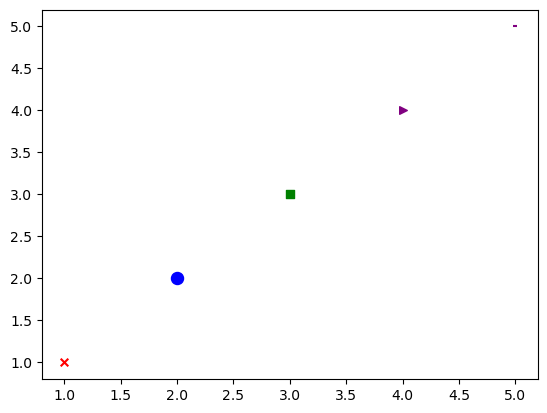

In [117]:
#this for making the legends for the graphs below
fig, ax = plt.subplots()
blue_airfield = ax.scatter(2,2, color='blue', s=75, marker='o', label='airfield')
red_hospital = ax.scatter(1,1, color='red', s=30, marker='x', label='hospital')
green_shelter = ax.scatter(3,3, color='green', s=30, marker='s', label='shelter')
arrow = ax.scatter(4,4, color='purple', s=30, marker='>', label='arrow')
route2 = ax.scatter(5,5, color='purple', s=10, marker='_', label='route')

In [118]:
colors = [r'#4285F4', r'#EA4335', r'#FBBC05', r'#34A853', r'#101010', r'#FFFFFF', r'#033E3E', r'#2C3539', r'#4E5B31',r'#DAEE01', r'#FFDB58', 
              r'#F2BB66', r'#FFA600', r'#BDB76B', r'#CD853F',r'#806517', r'#665D1E', 
              r'#483C32', r'#473810', r'#3B2F2F', r'#622F22',r'#644117', r'#7E3517',
              r'#A55D35', r'#CC6600', r'#FF8C00', r'#E55451',r'#F67280', r'#E55451',
              r'#FF4500', r'#FD1C03', r'#C11B17', r'#800000',r'#551606', r'#560319',
              r'#550A35', r'#7D0552', r'#F6358A', r'#A74AC7', r'#EE5130']
#40 random colors picked by team member for 40 vehicles

/tmp/ipykernel_1572/1591693842.py:2: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes.scatter(


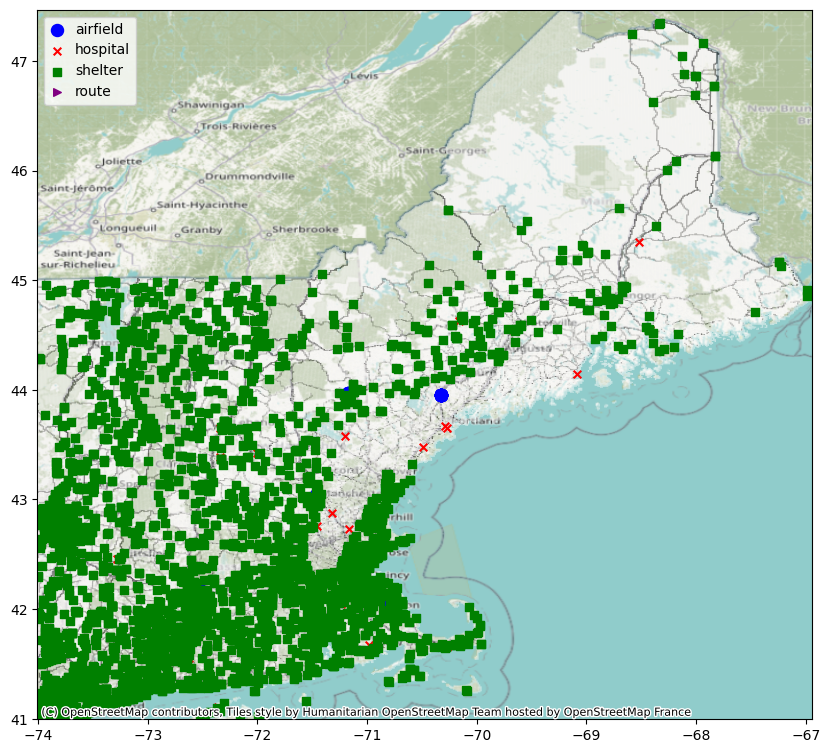

In [119]:
fig,axes = plt.subplots(figsize=(10,10))



marker_size = 1
plt.legend([blue_airfield, red_hospital, green_shelter, arrow],["airfield","hospital","shelter", "route"], handlelength=1)
axes.set_xlim([w, e])
axes.set_ylim([s, n])
#axes.set_axisbelow(True)


game_grid.plot(column='transport_score', ax=axes, alpha=0.5, cmap='Greys')
ctx.add_basemap(axes, crs=game_grid.crs)



for i, location in locations.iterrows():
    if location['tag'] == 'airfield':
        color = 'blue'
        marker = 'o'

    elif location['tag'] == 'hospital':
        color = 'red'
        marker = 'x'

    else:
        color = 'green'
        marker = 's'

    size = 75 if location['tag'] == 'airfield' else 30
    point = location['geometry'].centroid
    plot_location(point, axes, color, size, marker=marker)

/tmp/ipykernel_1572/1591693842.py:2: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes.scatter(


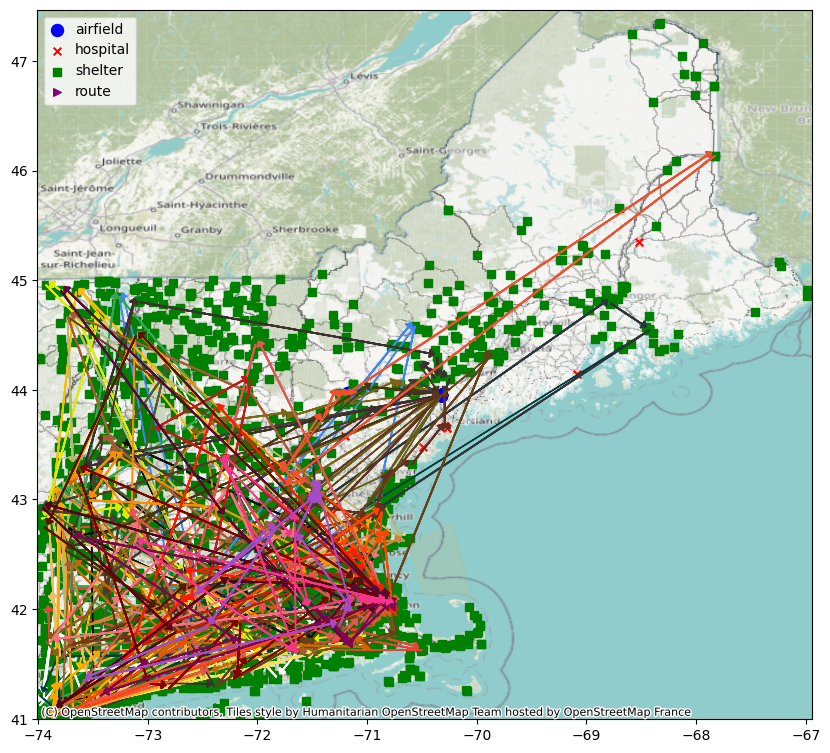

In [121]:

fig,axes = plt.subplots(figsize=(10,10))



marker_size = 1
plt.legend([blue_airfield, red_hospital, green_shelter, arrow],["airfield","hospital","shelter", "route"], handlelength=1)
axes.set_xlim([w, e])
axes.set_ylim([s, n])
#axes.set_axisbelow(True)


game_grid.plot(column='transport_score', ax=axes, alpha=0.5, cmap='Greys')
ctx.add_basemap(axes, crs=game_grid.crs)



for i, location in locations.iterrows():
    if location['tag'] == 'airfield':
        color = 'blue'
        marker = 'o'

    elif location['tag'] == 'hospital':
        color = 'red'
        marker = 'x'

    else:
        color = 'green'
        marker = 's'

    size = 75 if location['tag'] == 'airfield' else 30
    point = location['geometry'].centroid
    plot_location(point, axes, color, size, marker=marker)


#Plot arrows
for vehicle_ix, route in enumerate(routes):
    start_index = route[0]
    airfield_ix = start_index

    for i in range(1, len(route)):
        end_index = route[i]
        #print(end_index)
        start = locations.loc[start_index,'geometry'].centroid
        end = locations.loc[end_index,'geometry'].centroid
        end_tag = locations.loc[end_index,'tag']
        delta_x = end.x - start.x
        delta_y = end.y - start.y
        delta_length = math.sqrt(delta_x**2 + delta_y**2)
        if delta_length != 0:
            #ensure arrow heads dont actually touch markers
            
            if delta_x < 0:
                delta_x += 0.03
            else:
                delta_x -= 0.03

            if delta_y <0:
                delta_y += 0.03
            else:
                delta_y += 0.03
            
            axes.arrow(start.x,
                       start.y,
                       delta_x,
                       delta_y,
                       width=0.003,
                       head_width=0.07, head_length=0.04,
                       facecolor=colors[vehicle_ix],
                       edgecolor=colors[vehicle_ix],
                       length_includes_head=True)

        start_index = end_index
            
    #axes.legend(label = "Airfield " + str(airfield_ix), handle=[axes])
        

plt.show()
#print(routes)

In [130]:
def get_route(start_point, end_point):
    start_node = get_closest_node(start_point)
    end_node = get_closest_node(end_point)

    #print(start_node)
    #print(end_node)
    try:
        path_nodes = networkx.shortest_path(transport_network, source=start_node, target=end_node, weight='travel_time')

    except nx.NetworkXNoPath:
        return None
        
    #print(path_nodes)
    path_coords = [(transport_network.nodes[node]['x'], transport_network.nodes[node]['y']) for node in path_nodes]
    #print(path_coords)
    if len(path_coords) < 2:
        return None
    return LineString(path_coords)

/tmp/ipykernel_1572/1591693842.py:2: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes.scatter(


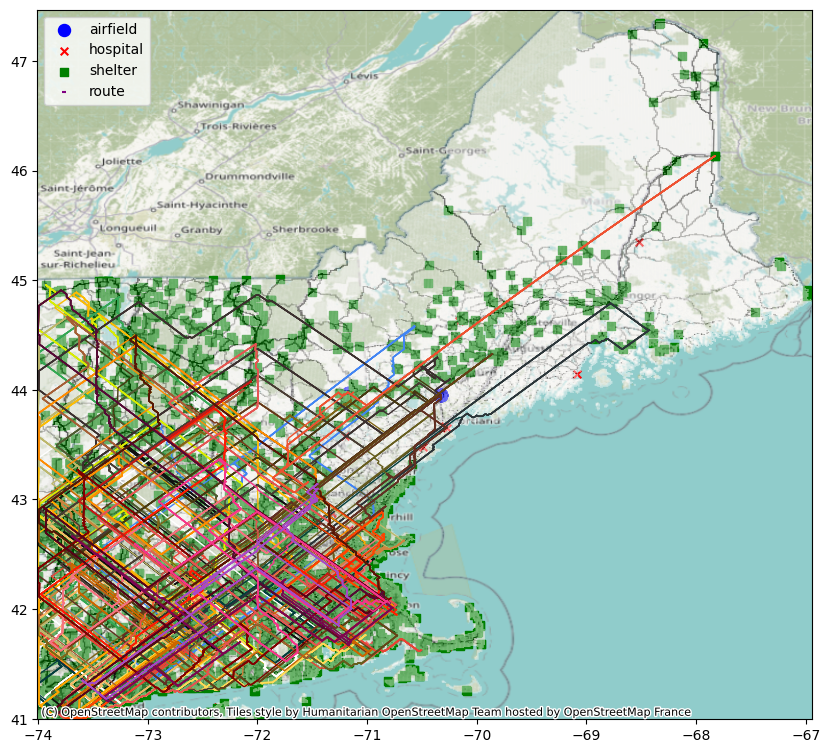

In [131]:
fig,axes = plt.subplots(figsize=(10,10))

marker_size = 1

axes.set_xlim([w, e])
axes.set_ylim([s, n])
axes.legend([blue_airfield, red_hospital, green_shelter, route2],["airfield","hospital","shelter","route"])
#axes.set_axisbelow(True)
for i, location in locations.iterrows():
    if location['tag'] == 'airfield':
        color = 'blue'
        marker = 'o'

    elif location['tag'] == 'hospital':
        color = 'red'
        marker = 'x'

    else:
        color = 'green'
        marker = 's'

    size = 75 if location['tag'] == 'airfield' else 30
    point = location['geometry'].centroid
    plot_location(point, axes, color, size, marker=marker)


game_grid.plot(column='transport_score', ax=axes, alpha=0.5, cmap='Greys')
ctx.add_basemap(axes, crs=game_grid.crs)


for vehicle_ix, route in enumerate(routes):
    start_index = route[0]
    airfield_ix = start_index

    for i in range(1, len(route)):
        end_index = route[i]
        start = locations.loc[start_index,'geometry'].centroid
        end = locations.loc[end_index,'geometry'].centroid
        #print(start, end)
        end_tag = locations.loc[end_index]['tag']
        if start != end:
            route_line = get_route(start, end)
            if route_line != None:       
                x, y = route_line.xy
                axes.plot(x,y, color=colors[vehicle_ix], linewidth=1)

        start_index = end_index
            


red_circle = plot_location(point, axes, color, size, marker=marker)
line_down, = ax.plot([3, 2, 1], label='Line 1')

#print(routes)

In [133]:
#total num dropped locations
routes_flat = list(itertools.chain.from_iterable(routes))
count = 0
for loc in range(len(locations)):
    if loc not in routes_flat:
        count += 1
        #print(loc)

print(count)

3752
